<a href="https://colab.research.google.com/github/ofekrosenfeld1/thesis/blob/main/vae_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import relevant libraries
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import json
from torch.nn.utils.rnn import pad_sequence
import ast
from multiprocessing import Pool
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader



In [2]:
repo = 'https://github.com/ofekrosenfeld1/thesis.git'
!git clone $repo

fatal: destination path 'thesis' already exists and is not an empty directory.


#connect to drive and mount the relevant dataframe from drive

In [1]:
#connect to google drive in order to mount files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load the chembl pre-processed data into the notebook
chembl_df = pd.read_csv('/content/drive/My Drive/chembl_relevant_info_with_numeric_selfies.csv')
chembl_df = chembl_df.drop(columns=['Unnamed: 0','Unnamed: 0.1','ChEMBL ID'])

In [ ]:
print(chembl_df['SELFIES'][12345])

[C][C][=Branch1][C][=O][N][C][C][C][C][Branch2][Ring1][=N][C][=C][C][=C][Branch2][Ring1][C][C][C][O][C][=C][C][Branch1][C][Cl][=C][C][Branch1][C][Cl][=C][Ring1][Branch2][C][=C][Ring1][P][=C][Branch2][Ring1][Ring1][C][=Branch1][C][=O][N][Branch1][C][C][C][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][Branch1][C][Ring2][Ring2][Branch1][N][Ring2][Ring2][Ring2][EOS]


In [ ]:
#load the covnersion idxs jsons (selfies - numeric representation and vice versia)
with open('/content/drive/My Drive/idx_to_token.json','r') as f:
    idx_to_tokens = json.load(f)

with open('/content/drive/My Drive/token_to_indx.json','r') as f:
    tokens_to_idx = json.load(f)

In [ ]:
print((idx_to_tokens['211']))
print((tokens_to_idx['[N-1]']))

[N-1]
211


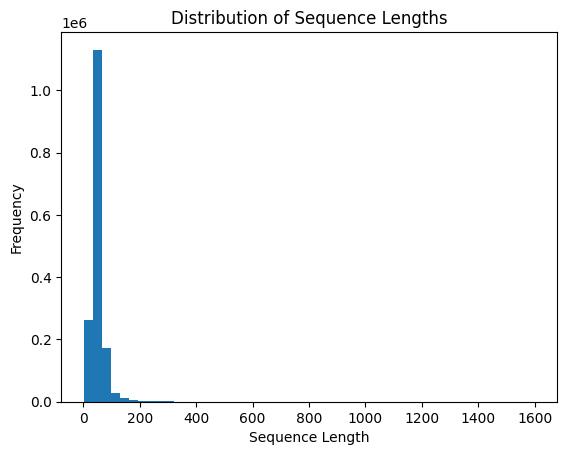

In [ ]:
chembl_df['seq_len'] = chembl_df['numeric_selfies'].str.count(',') + 1
plt.figure()
plt.hist(chembl_df['seq_len'], bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [ ]:
percentile_90 = chembl_df['seq_len'].quantile(0.90)
print(percentile_90)

71.0


In [ ]:
def fast_parse_and_pad(s, max_len, pad_value=0):
    """
    Converts stringified numeric SELFIE to a fixed-length tensor.
    Truncates if too long, pads with `pad_value` if too short.
    """
    tokens = list(map(int, s.strip('[]').replace(' ', '').split(',')))
    tokens = tokens[:max_len]  # Truncate if longer than max_len

    # Pad to max_len
    if len(tokens) < max_len:
        tokens += [pad_value] * (max_len - len(tokens))

    return torch.tensor(tokens, dtype=torch.long)

def process_molecules_fixed_length(df, column, max_len, pad_value=0):
    """
    Vectorized fixed-length processing of numeric SELFIE strings.
    Returns a list of torch tensors, one per molecule.
    """
    return df[column].apply(lambda s: fast_parse_and_pad(s, max_len, pad_value)).tolist()

In [ ]:
tensors = process_molecules_fixed_length(df = chembl_df, column='numeric_selfies', max_len=71, pad_value=0)

In [ ]:
print(((tensors[10])))
print(len(tensors))

tensor([182, 232, 182, 115, 182, 115, 170, 244, 223, 223, 182, 115, 182, 115,
        169, 115, 232, 182, 182, 115, 182, 115, 182, 169, 182, 192, 115, 244,
          4, 182, 169, 182, 188, 115, 244, 258, 223, 115, 223, 115, 245, 244,
          4, 182, 115, 245, 244, 232, 232, 182, 182, 182, 182, 182, 223, 182,
        115, 223, 115, 244, 169, 210, 112, 182, 122, 227, 190,   0,   0,   0,
          0])
1623356


In [ ]:

tensors_for_model = tensors
#process the tensors to be a model-ready data
#stack the tensors to be in one tensor of shape [N, seq_len]
x_tensor = torch.stack(tensors_for_model)
#use pytorch approach of creating a dataset object of the big tensor we created before
dataset = TensorDataset(x_tensor)
#load the data using the needed batch_size, while shuffling the data every epoch
dataloader = DataLoader(dataset, batch_size= 64, shuffle=True)



In [ ]:
#the main VAE class, inherits from nn.Module
class SelfiesVAE(nn.Module):
    #init gets the base properties of the class
    #vocab_size = number of tokens in the vocabulary (of the selfies)
    #pad_idx = the token used to represent the padding
    def __init__(self, vocab_size, embedding_dim, hidden_dim, latent_dim, pad_idx,seq_len):
        #super().__init__() is needed for inheritance of nn.Module properties
        super().__init__()
        #the tensor by itself does not contribute any information - or chemical inforamtion, hence an embedding is needed for each SELFIE
        #better than one-hot due to lower dim. vector and more information can be passed through embeddings
        #padding_idx helps the embedding to know which index was used for padding the tensor - to not count them in the backprop
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        #after the embedding layer, the data is encoded into rnn (gru)
        self.encoder_rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        #then, the mu and logvar are generated - latent space
        self.to_mu = nn.Linear(hidden_dim, latent_dim)
        self.to_logvar = nn.Linear(hidden_dim, latent_dim)
        #then, the latent space is converted into the hidden linear layer
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        #after going through to the hidden layer, it is potentially possible to add act. func. -can experiment w/ that
        #finally, we decode through a gru layer
        self.decoder_rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        #then - we finally have an output through a linear layer
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
        #the fixed lenght of a sequence (molecule), defined in the EDA steps
        self.seq_len = seq_len
        #padding index = 0
        self.pad_idx = pad_idx


    def encode(self, x):
        #x.long() makes the input in the correct format (int) into the embedding, embedding layer accepts integers
        x_embed = self.embedding(x.long())
        #gets the embedded and encode it through gru
        #the output of the gru is outputs, h - but we just want the h, not all the outputs. we are interested in the summery vector of all the timesteps in the gru
        _, h = self.encoder_rnn(x_embed)
        #take just the needed dimentions
        h = h.squeeze(0)
        #get the mu out of h
        mu = self.to_mu(h)
        #get the logvar out of h
        logvar = self.to_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        #reparametrization trick - using z = mu + std*eps~N(0,1), this allows to backprop through mu,std - while eps~N(0,1) stays the same
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, seq_len):
        #first, the z latent vector is decoded through linear layer that maps it into the shpe expected by the gru
        hidden = self.latent_to_hidden(z).unsqueeze(0)
        #get the batch size through z(0) - z is [batch_size, latent_vec_size]
        batch_size = z.size(0)
        #we need an initial input token to insert the gru - using the pad_idx as initial token
        #the shape of the initial input is [batch_size,1]
        #torch.long to match the expected type of embedded, then sending it to device
        #the "dummy input token" is common usage as an initializer of the gru
        input_token = torch.full((batch_size, 1), self.pad_idx, dtype=torch.long, device=z.device)
        outputs = []

        #each time the gru predicts the next token, so we iterate on each token in the seq_len
        for _ in range(seq_len):
            #get the embdedding of the input token - to get embedding vector of the token
            embed = self.embedding(input_token)
            #get the prediction (out) of the next token from the gru - based on the previous token
            out, hidden = self.decoder_rnn(embed, hidden)
            #logits are with shape [batch_size, vocab_size] meaning it maps the probability of each token from the vocabulary based on the output from the gru
            #now, instead of each token we have a vector w/ probability of each possible token. remember we have a batch each time so its [batch_size, vocab_size]
            logits = self.output_layer(out.squeeze(1))
            #save the logits of each timestep
            outputs.append(logits)
            input_token = logits.argmax(dim=1, keepdim=True)  # Greedy decoding
        #the results is stacked list of the output logits for each timestep
        return torch.stack(outputs, dim=1)  # [B, L, V]


    def forward(self, x):
      #forward is important func. - as it inherits from nn.Module to be activates once the model is called
      #the output of the forward is the logits (distr. for each token in each timestep) after the decoding, plus the mu,std of the latent space
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat_logits = self.decode(z, x.size(1))
        return x_hat_logits, mu, logvar


# === Loss Function ===

def vae_loss(x_hat_logits, x_true, mu, logvar, pad_idx):
  #we use the cross_entropy as the reconstruction loss - makes the most sense
  #here we do it token by token
  #the -1 flattens it
  #ignoring the pad index for loss calc ofc
  #
    recon_loss = F.cross_entropy(
        x_hat_logits.view(-1, x_hat_logits.size(-1)),
        x_true.view(-1),
        ignore_index=pad_idx,
        reduction='mean'
    )
    #also, we use the kl divergence as a regularization that the latent dist. behave like a gaussian dist. - keepin it as smooth as possible
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div, recon_loss, kl_div


# === Training Setup ===

def train_vae(model, dataloader, optimizer, device, pad_idx, num_epochs):
    #sets the params into training setup
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        total_recon = 0
        total_kl = 0
        #loop is an approach to define dataloader just with tdqm method(for process bars)
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        #looping through each batch
        for (x_batch,) in loop:
            x_batch = x_batch.to(device)
            #first resetting the gradients in the optimizer - independent each batch
            optimizer.zero_grad()
            #calc the x_hat, mu,var with model(batch) -> applying forward method
            x_hat_logits, mu, logvar = model(x_batch)
            #calc loss of the output
            loss, recon, kl = vae_loss(x_hat_logits, x_batch, mu, logvar, pad_idx)
            #do backprop based on the loss
            loss.backward()
            #update the model weights properly to the backprop
            optimizer.step()
            #collecting info for each loop to estimate how the model did over epochs
            #loss is a tensor, hence by .item() you get the number only
            total_loss += loss.item()
            total_recon += recon.item()
            total_kl += kl.item()
            loop.set_postfix(loss=loss.item(), recon=recon.item(), kl=kl.item())

        print(f"Epoch {epoch+1} - Loss: {total_loss:.2f}, Recon: {total_recon:.2f}, KL: {total_kl:.2f}")


In [ ]:

if __name__ == "__main__":
    #vocab size is the size of your unique tokens in your index, including padding idx
    vocab_size = len(idx_to_tokens)
    #seqeunce lenght - fixed lenght for all tensors describing the molecules, predefined before
    seq_len = 71
    #embedding size vector initialy set to 256
    embedding_dim = 256
    #hidden layer also 256
    hidden_dim = 256
    #latent dim would be 64
    latent_dim = 64
    #padding idx is 0
    pad_idx = 0
    #10 epochs, 32 molecules each time
    num_epochs = 20
    batch_size = 64
    learning_rate = 1e-3
    #set up the model with the dimenstions mentioned before
    model = SelfiesVAE(vocab_size, embedding_dim, hidden_dim, latent_dim, pad_idx,seq_len)
    #set up the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #send model to device
    model = SelfiesVAE(vocab_size, embedding_dim, hidden_dim, latent_dim, pad_idx,seq_len).to(device)
    #set up the ADAM optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Train the model
    train_vae(model, dataloader, optimizer, device, pad_idx, num_epochs)

Epoch 1/20: 100%|██████████| 25365/25365 [32:06<00:00, 13.17it/s, kl=0.2, loss=1.99, recon=1.79]


Epoch 1 - Loss: 54271.84, Recon: 50690.51, KL: 3581.33


Epoch 2/20: 100%|██████████| 25365/25365 [32:08<00:00, 13.15it/s, kl=0.248, loss=1.99, recon=1.74]


Epoch 2 - Loss: 51236.66, Recon: 45473.52, KL: 5763.14


Epoch 3/20: 100%|██████████| 25365/25365 [32:12<00:00, 13.13it/s, kl=0.279, loss=1.91, recon=1.63]


Epoch 3 - Loss: 49870.86, Recon: 43219.10, KL: 6651.77


Epoch 4/20: 100%|██████████| 25365/25365 [31:53<00:00, 13.26it/s, kl=0.298, loss=1.93, recon=1.63]


Epoch 4 - Loss: 48800.11, Recon: 41490.70, KL: 7309.41


Epoch 5/20: 100%|██████████| 25365/25365 [31:44<00:00, 13.32it/s, kl=0.315, loss=1.84, recon=1.53]


Epoch 5 - Loss: 47618.05, Recon: 39647.80, KL: 7970.24


Epoch 6/20: 100%|██████████| 25365/25365 [31:35<00:00, 13.38it/s, kl=0.331, loss=1.88, recon=1.55]


Epoch 6 - Loss: 47263.57, Recon: 38700.50, KL: 8563.07


Epoch 7/20:  57%|█████▋    | 14515/25365 [18:18<13:38, 13.25it/s, kl=0.351, loss=1.88, recon=1.53]

In [ ]:
#saving the model paramaters in drive to re-use them later on for further experiment
# save only the model parameters (recommended)
torch.save(model.state_dict(), 'vae_selfies_all_data_exp.pt')
#download to the local machine (optional)
from google.colab import files
files.download('vae_selfies_all_data_exp.pt')
#save to google drive
torch.save(model.state_dict(), '/content/drive/MyDrive/vae_selfies_all_data_exp.pt')

In [ ]:
#loading saved weights from saved weights of experimental model
vocab_size = len(idx_to_tokens)
seq_len = 71
embedding_dim = 256
hidden_dim = 256
latent_dim = 64
pad_idx = 0
num_epochs = 20
batch_size = 64
learning_rate = 1e-3
model = SelfiesVAE(vocab_size, embedding_dim, hidden_dim, latent_dim, pad_idx,seq_len)
#set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#send model to device
model = SelfiesVAE(vocab_size, embedding_dim, hidden_dim, latent_dim, pad_idx,seq_len).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/vae_selfies_500k_first_exp.pt'))

<All keys matched successfully>

In [ ]:
from __future__ import generator_stop
#NOW - generate a new molecule from the VAE based on an input molecule
mol = tensors[1000000]
print(mol)
x = mol.unsqueeze(0).to(device)
#use eval mode - to not accidently activate all the behaviors of .train() mode
# make sure model is in eval mode - no_grad saves memory and time, ensure inference mode
model.eval()
with torch.no_grad():
    #encode the mu, logvar that represents your molecule
    mu, logvar = model.encode(x)
    z = model.reparameterize(mu, logvar)  # shape: [1, latent_dim]
    #decode your sampled molecule from the latent space
    logits = model.decode(z, seq_len)
    token_ids = logits.argmax(dim=2)[0]  # [seq_len]
    generated_tokens = [idx_to_tokens[str(i.item())] for i in token_ids]
    original_mol = [idx_to_tokens[str(i.item())] for i in x[0]]
    print(generated_tokens, len(generated_tokens))
    print(original_mol, len(original_mol))


tensor([182, 182, 169, 182, 182, 169, 182, 182, 182, 115, 258, 182, 170, 245,
        245, 223, 182, 112, 182, 122, 182, 182, 115, 223, 169,   5, 182, 182,
        115, 182, 115, 182, 115, 244, 112, 182, 115, 182, 115, 169, 244, 182,
          9, 182, 115, 245, 244, 182, 244, 170, 120, 245, 244, 232, 190,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0])
['[C]', '[C]', '[Branch1]', '[C]', '[C]', '[Branch1]', '[C]', '[C]', '[C]', '[=C]', '[C]', '[=C]', '[Branch2]', '[Ring1]', '[P]', '[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[Ring1]', '[Ring1]', '[C]', '[C]', '[C]', '[Ring2]', '[Ring1]', '[Ring1]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[EOS]'] 71
['[C]',